# Calibrate a Stereocamera

In [1]:
import cv2
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

ModuleNotFoundError: No module named 'cv2'

## Constants

In [2]:
SQUARE_SIZE = 30     # how big are the squares of the checkerboard pattern (in millimeters)
BOARD_SIZE = (11,7)  # size of the chessboard (measured from the crossing corners of the squares)

## Look at the Data

In [3]:
LEFT_PATH = '../data/data/imgs/leftcamera'
RIGHT_PATH = '../data/data/imgs/rightcamera'

print('We have {} Images from the left camera'.format(len(os.listdir(LEFT_PATH))))
print('and {} Images from the right camera.'.format(len(os.listdir(RIGHT_PATH))))

We have 20 Images from the left camera
and 20 Images from the right camera.


In [4]:
# sort the image names after their number
# save the image names with the whole path in a list

print('Before: {}, {}, {}, ...'.format(os.listdir(LEFT_PATH)[0], os.listdir(LEFT_PATH)[1], os.listdir(LEFT_PATH)[2]))

def SortImageNames(path):
    imagelist = sorted(os.listdir(path))
    lengths = []
    for name in imagelist:
        lengths.append(len(name))
    lengths = sorted(list(set(lengths)))
    ImageNames, ImageNamesRaw = [], []
    for l in lengths:
        for name in imagelist:
            if len(name) == l:
                ImageNames.append(os.path.join(path, name))
                ImageNamesRaw.append(name)
    return ImageNames
                
Left_Paths = SortImageNames(LEFT_PATH)
Right_Paths = SortImageNames(RIGHT_PATH)

print('After: {}, {}, {}, ...'.format(os.path.basename(Left_Paths[0]), os.path.basename(Left_Paths[1]), os.path.basename(Left_Paths[2])))

Before: Im_L_1.png, Im_L_10.png, Im_L_11.png, ...
After: Im_L_1.png, Im_L_2.png, Im_L_3.png, ...


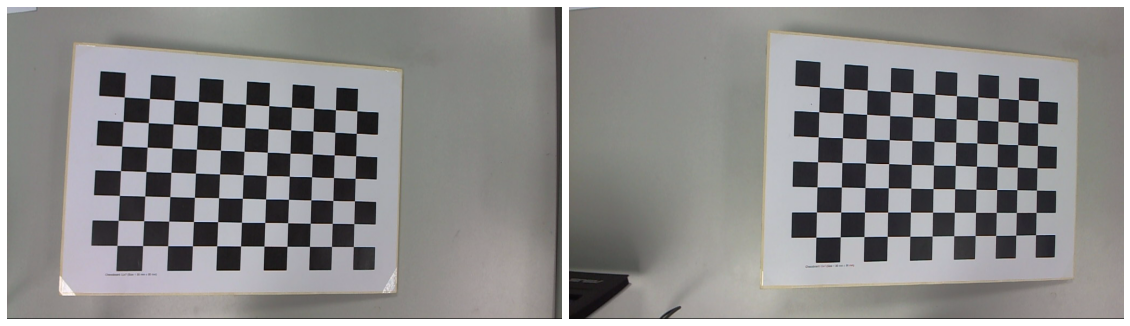

In [5]:
# let's look at an example picture pair from the left and right camera
# the image pairs showing the same scenario at the same time, but from differnt points of view.

fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)

for ax, im in zip(grid, [Left_Paths[15], Right_Paths[15]]):
    ax.imshow(plt.imread(im))
    ax.axis('off')

In [6]:
# we need to check if we have the correct Board Size

example_image = cv2.imread(Left_Paths[5])
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2GRAY)

ret, _ = cv2.findChessboardCorners(example_image, BOARD_SIZE)
if ret:
    print('Board Size {} is correct.'.format(BOARD_SIZE))
else:
    print('[ERROR] the Board Size is not correct!')
    BOARD_SIZE = (0,0)

Board Size (11, 7) is correct.


## Detect the Chessboard Corners

In [7]:
# we have to create the objectpoints
# that are the local 2D-points on the pattern, corresponding 
# to the local coordinate system on the top left corner.

objpoints = np.zeros((BOARD_SIZE[0]*BOARD_SIZE[1], 3), np.float32)
objpoints[:,:2] = np.mgrid[0:BOARD_SIZE[0], 0:BOARD_SIZE[1]].T.reshape(-1,2)
objpoints *= SQUARE_SIZE

In [8]:
# now we have to find the imagepoints
# these are the same points like the objectpoints but depending
# on the camera coordination system in 3D
# the imagepoints are not the same for each image/camera

def GenerateImagepoints(paths):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    imgpoints = []
    for name in paths:
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners1 = cv2.findChessboardCorners(img, BOARD_SIZE)
        if ret:
            corners2 = cv2.cornerSubPix(gray, corners1, (4,4), (-1,-1), criteria)
            imgpoints.append(corners2)
    return imgpoints

Left_imgpoints = GenerateImagepoints(Left_Paths)
Right_imgpoints = GenerateImagepoints(Right_Paths)

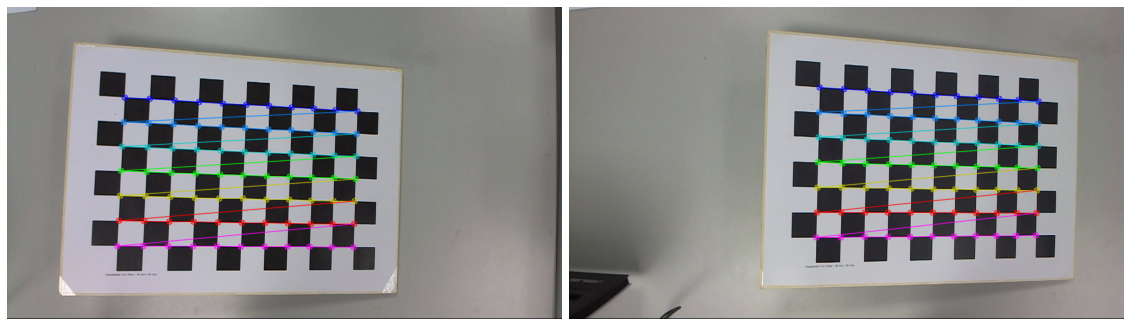

In [9]:
# we also can display the imagepoints on the example pictures.

def DisplayImagePoints(path, imgpoints):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.drawChessboardCorners(img, BOARD_SIZE, imgpoints, True)
    return img
    
example_image_left = DisplayImagePoints(Left_Paths[15], Left_imgpoints[15])
example_image_right = DisplayImagePoints(Right_Paths[15], Right_imgpoints[15])

fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)

for ax, im in zip(grid, [example_image_left, example_image_right]):
    ax.imshow(im)
    ax.axis('off')

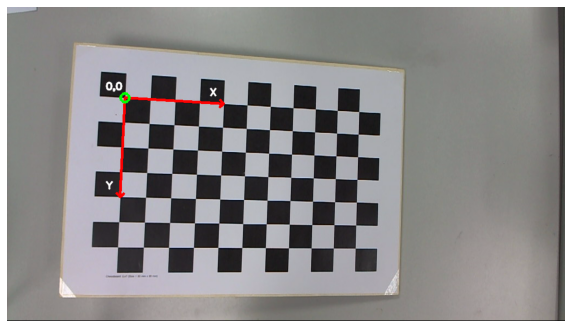

In [10]:
# in this picture we now see the local coordinate system of the chessboard
# the origin is at the top left corner
# the orientation is like: long side = X

def PlotLocalCoordinates(img, points):
    points = np.int32(points)
    cv2.arrowedLine(img, tuple(points[0,0]), tuple(points[4,0]), (255,0,0), 3, tipLength=0.05)
    cv2.arrowedLine(img, tuple(points[0,0]), tuple(points[BOARD_SIZE[0]*4,0]), (255,0,0), 3, tipLength=0.05)
    cv2.circle(img, tuple(points[0,0]), 8, (0,255,0), 3)
    cv2.putText(img, '0,0', (points[0,0,0]-35, points[0,0,1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(img, 'X', (points[4,0,0]-25, points[4,0,1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(img, 'Y', (points[BOARD_SIZE[0]*4,0,0]-25, points[BOARD_SIZE[0]*4,0,1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)
    return img

n = 15
img = cv2.imread(Left_Paths[n])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = PlotLocalCoordinates(img, Left_imgpoints[n])

fig = plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

## Camera Calibration

In [11]:
Start_Time_Cal = time.perf_counter()

In [12]:
def CalibrateCamera(paths, imgpoints, objpoints):
    CameraParams = {}
    
    gray = cv2.cvtColor(cv2.imread(Left_Paths[0]), cv2.COLOR_BGR2GRAY)
    g = gray.shape[::-1]
    
    flags = 0
    
    objp = []
    for i in range(20):
        objp.append(objpoints)
    (ret, mtx, dist, rvecs, tvecs) = cv2.calibrateCamera(objp, imgpoints, g, None, None, flags=flags)
    
    Rmtx = []; Tmtx = []; k = 0
    for r in rvecs: 
        Rmtx.append(cv2.Rodrigues(r)[0])
        Tmtx.append(np.vstack((np.hstack((Rmtx[k],tvecs[k])),np.array([0,0,0,1]))))
        k += 1
        
    img = cv2.imread(Left_Paths[0],0)
    h,w = img.shape[:2]
    newmtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

    if np.sum(roi) == 0:
        roi = (0,0,w-1,h-1)
        
    CameraParams['Intrinsic'] = mtx
    CameraParams['Distortion'] = dist
    CameraParams['DistortionROI'] = roi
    CameraParams['DistortionIntrinsic'] = newmtx
    CameraParams['RotVektor'] = rvecs
    CameraParams['RotMatrix'] = Rmtx
    CameraParams['Extrinsics'] = Tmtx
    CameraParams['TransVektor'] = tvecs
    
    return CameraParams

In [13]:
Left_Params = CalibrateCamera(Left_Paths, Left_imgpoints, objpoints)
Right_Params = CalibrateCamera(Right_Paths, Right_imgpoints, objpoints)

In [14]:
# let's look at the calibrated parameters from the left camera

np.set_printoptions(suppress=True, precision=5)
print('Intrinsic Matrix:')
print(Left_Params['Intrinsic'])
print('\nDistortion Parameters:')
print(Left_Params['Distortion'])
print('\nExtrinsic Matrix from 1.Image:')
print(Left_Params['Extrinsics'][0])

Intrinsic Matrix:
[[717.67713   0.      524.328  ]
 [  0.      728.74458 285.48227]
 [  0.        0.        1.     ]]

Distortion Parameters:
[[ 0.03202 -0.17514  0.0009   0.00049  0.19902]]

Extrinsic Matrix from 1.Image:
[[   0.99975   -0.02139    0.00673 -274.73083]
 [   0.02112    0.99904    0.03826 -120.77909]
 [  -0.00754   -0.03811    0.99925  541.73051]
 [   0.         0.         0.         1.     ]]


## Reprojection Errors

In [15]:
def CalculateErrors(params, imgpoints, objpoints):
    imgp = np.array(imgpoints)
    imgp = imgp.reshape((imgp.shape[0], imgp.shape[1], imgp.shape[3]))
    objp = np.array(objpoints)
    K = np.array(params['Intrinsic'])
    D = np.array(params['Distortion'])
    R = np.array(params['RotVektor'])
    T = np.array(params['TransVektor'])
    N = imgp.shape[0]
    
    imgpNew = []
    for i in range(N):
        temp, _ = cv2.projectPoints(objp, R[i], T[i], K, D)
        imgpNew.append(temp.reshape((temp.shape[0], temp.shape[2])))
    imgpNew = np.array(imgpNew)
    
    err = []
    for i in range(N):
        err.append(imgp[i] - imgpNew[i])
    err = np.array(err)
    
    def RMSE(err):
        return np.sqrt(np.mean(np.sum(err**2, axis=1)))

    errall = np.copy(err[0])
    rmsePerView = [RMSE(err[0])]
    for i in range(1,N):
        errall = np.vstack((errall, err[i]))
        rmsePerView.append(RMSE(err[i]))

    rmseAll = RMSE(errall)
    return rmsePerView, rmseAll

In [16]:
Left_Errors, Left_MeanError = CalculateErrors(Left_Params, Left_imgpoints, objpoints)
Right_Errors, Right_MeanError = CalculateErrors(Right_Params, Right_imgpoints, objpoints)

print('Reprojection Error Left:  {:.4f}'.format(Left_MeanError))
print('Reprojection Error Right: {:.4f}'.format(Right_MeanError))

Reprojection Error Left:  0.1914
Reprojection Error Right: 0.2033


In [17]:
Left_Params['Imgpoints'] = Left_imgpoints
Left_Params['Errors'] = Left_Errors
Left_Params['MeanError'] = Left_MeanError

Right_Params['Imgpoints'] = Right_imgpoints
Right_Params['Errors'] = Right_Errors
Right_Params['MeanError'] = Right_MeanError

## Stereo Camera Calibration

In [18]:
def StereoCalibration(leftparams, rightparams, objpoints, imgpL, imgpR, Left_Paths, Right_Paths):
    StereoParams = {}
    
    k1 = leftparams['Intrinsic']
    d1 = leftparams['Distortion']
    k2 = rightparams['Intrinsic']
    d2 = rightparams['Distortion']
    gray = cv2.imread(Left_Paths[0], 0)
    g = gray.shape[::-1]
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)
    flags = 0
    flags |= cv2.CALIB_FIX_INTRINSIC
    
    objp = []
    for i in range(20):
        objp.append(objpoints)
    
    (ret, K1, D1, K2, D2, R, t, E, F) = cv2.stereoCalibrate(objp, imgpL, imgpR, k1, d1, k2, d2, g, criteria=criteria, flags=flags)
    
    T = np.vstack((np.hstack((R,t)),np.array([0,0,0,1])))
    
    StereoParams['Transformation'] = T
    StereoParams['Essential'] = E
    StereoParams['Fundamental'] = F
    StereoParams['MeanError'] = ret
    return StereoParams

In [19]:
Stereo_Params = StereoCalibration(Left_Params, Right_Params, objpoints, Left_imgpoints, Right_imgpoints, Left_Paths, Right_Paths)

In [20]:
print('Transformation Matrix:')
print(Stereo_Params['Transformation'])
print('\nEssential Matrix:')
print(Stereo_Params['Essential'])
print('\nFundamental Matrix:')
print(Stereo_Params['Fundamental'])
print('\nMean Reprojection Error:')
print('{:.6f}'.format(Stereo_Params['MeanError']))

Transformation Matrix:
[[  0.99937   0.00764  -0.03461 189.73626]
 [ -0.00857   0.9996   -0.02685  -4.5265 ]
 [  0.03439   0.02713   0.99904   4.79117]
 [  0.        0.        0.        1.     ]]

Essential Matrix:
[[  -0.11461   -4.91205   -4.39353]
 [  -1.7366    -5.1103  -189.71999]
 [   2.89798  189.69547   -5.25048]]

Fundamental Matrix:
[[ 0.       0.       0.00061]
 [ 0.       0.       0.04731]
 [-0.00095 -0.0498   1.     ]]

Mean Reprojection Error:
0.210014


In [21]:
end = time.perf_counter() - Start_Time_Cal
print('elapsed time for calibration process: {:.2f} seconds.'.format(end))

elapsed time for calibration process: 61.16 seconds.


## Save the Parameters

In [22]:
Parameters = Stereo_Params
Parameters['SquareSize'] = SQUARE_SIZE
Parameters['BoardSize'] = BOARD_SIZE
Parameters['Objpoints'] = objpoints

for Lkey in Left_Params.keys():
    name = 'L_'+str(Lkey)
    Parameters[name] = Left_Params[Lkey]
    
for Rkey in Right_Params.keys():
    name = 'R_'+str(Rkey)
    Parameters[name] = Right_Params[Rkey]

In [23]:
# save the Parameters dictionary into an npz file
# with this file we can access the data afterwards very easy

file = 'parameters.npz'
np.savez(file, **Parameters)
npz = dict(np.load(file))
size = (npz['L_Imgpoints'].shape[0], npz['L_Imgpoints'].shape[1], npz['L_Imgpoints'].shape[3])
npz['L_Imgpoints'] = np.resize(npz.pop('L_Imgpoints'), size)
npz['R_Imgpoints'] = np.resize(npz.pop('R_Imgpoints'), size)
np.savez(file, **npz)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#51BC23;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Upvoting is for free ;)
        </p>
    </div>